In [1]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,VotingClassifier
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso, HuberRegressor, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import xgboost as xgb
import lightgbm as lgb
np.random.seed(25)

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,...,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE
0,P03210,Karapakkam,1004,04-05-2011,131,1.0,1.0,3,AbNormal,Yes,...,AllPub,Paved,A,4.0,3.9,4.9,4.330,380000,144400,7600000
1,P09411,Anna Nagar,1986,19-12-2006,26,2.0,1.0,5,AbNormal,No,...,AllPub,Gravel,RH,4.9,4.2,2.5,3.765,760122,304049,21717770
2,P01812,Adyar,909,04-02-2012,70,1.0,1.0,3,AbNormal,Yes,...,ELO,Gravel,RL,4.1,3.8,2.2,3.090,421094,92114,13159200
3,P05346,Velachery,1855,13-03-2010,14,3.0,2.0,5,Family,No,...,NoSewr,Paved,I,4.7,3.9,3.6,4.010,356321,77042,9630290
4,P06210,Karapakkam,1226,05-10-2009,84,1.0,1.0,3,AbNormal,Yes,...,AllPub,Gravel,C,3.0,2.5,4.1,3.290,237000,74063,7406250


In [4]:
train['N_BEDROOM'].value_counts()

1.0    3795
2.0    2352
3.0     707
4.0     254
Name: N_BEDROOM, dtype: int64

In [5]:
train.dtypes

PRT_ID            object
AREA              object
INT_SQFT           int64
DATE_SALE         object
DIST_MAINROAD      int64
N_BEDROOM        float64
N_BATHROOM       float64
N_ROOM             int64
SALE_COND         object
PARK_FACIL        object
DATE_BUILD        object
BUILDTYPE         object
UTILITY_AVAIL     object
STREET            object
MZZONE            object
QS_ROOMS         float64
QS_BATHROOM      float64
QS_BEDROOM       float64
QS_OVERALL       float64
REG_FEE            int64
COMMIS             int64
SALES_PRICE        int64
dtype: object

In [6]:
train.isnull().sum(axis=0)

PRT_ID            0
AREA              0
INT_SQFT          0
DATE_SALE         0
DIST_MAINROAD     0
N_BEDROOM         1
N_BATHROOM        5
N_ROOM            0
SALE_COND         0
PARK_FACIL        0
DATE_BUILD        0
BUILDTYPE         0
UTILITY_AVAIL     0
STREET            0
MZZONE            0
QS_ROOMS          0
QS_BATHROOM       0
QS_BEDROOM        0
QS_OVERALL       48
REG_FEE           0
COMMIS            0
SALES_PRICE       0
dtype: int64

In [7]:
train = train.fillna({"N_BEDROOM": train["N_BEDROOM"].mean(), "INT_SQFT": train["INT_SQFT"].mean(),
                     "N_BATHROOM": train["N_BATHROOM"].mean(), "QS_OVERALL": train["QS_OVERALL"].mean()})
test = test.fillna({"N_BEDROOM": test["N_BEDROOM"].mean(), "INT_SQFT": train["INT_SQFT"].mean(),
                     "N_BATHROOM": test["N_BATHROOM"].mean(), "QS_OVERALL": test["QS_OVERALL"].mean()})

# Feature Engineering

In [8]:
train['diff_reg_comm'] = train['REG_FEE'] - train['COMMIS']
test['diff_reg_comm'] = test['REG_FEE'] - test['COMMIS']

In [9]:
def get_month(x):
    txt = str(x)
    y = txt.split('-')
    if len(y) != 3:
        return 'None'
    return int(y[1])

def get_year(x):
    txt = str(x)
    y = txt.split('-')
    if len(y) != 3:
        return 'None'
    return int(y[2])

In [10]:
train['MONTH'] = train['DATE_SALE'].map(lambda x: get_month(x))
train['YEAR'] = train['DATE_SALE'].map(lambda x: get_year(x))

test['MONTH'] = test['DATE_SALE'].map(lambda x: get_month(x))
test['YEAR'] = test['DATE_SALE'].map(lambda x: get_year(x))

In [11]:
train['DATE_SALE'] = pd.to_datetime(train['DATE_SALE'].astype(str), format='%d-%m-%Y')
train['DATE_BUILD'] = pd.to_datetime(train['DATE_BUILD'].astype(str), format='%d-%m-%Y')

test['DATE_SALE'] = pd.to_datetime(test['DATE_SALE'].astype(str), format='%d-%m-%Y')
test['DATE_BUILD'] = pd.to_datetime(test['DATE_BUILD'].astype(str), format='%d-%m-%Y')

In [12]:
train['HOUSE_LIFETIME'] = train['DATE_SALE'] .subtract( train['DATE_BUILD'])
test['HOUSE_LIFETIME'] = test['DATE_SALE'] .subtract( test['DATE_BUILD'])

train['HOUSE_LIFETIME'] = train['HOUSE_LIFETIME'] .divide( np.timedelta64(1, 'D'))
test['HOUSE_LIFETIME'] = test['HOUSE_LIFETIME'] .divide( np.timedelta64(1, 'D'))

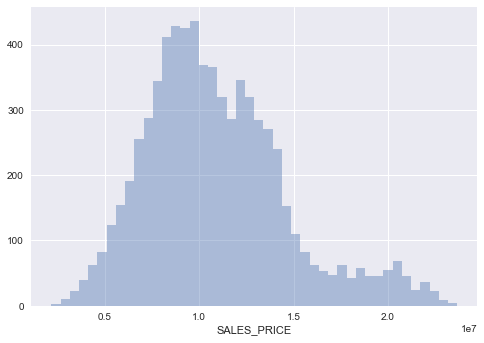

In [13]:
sns.distplot(train['SALES_PRICE'] , kde=False);

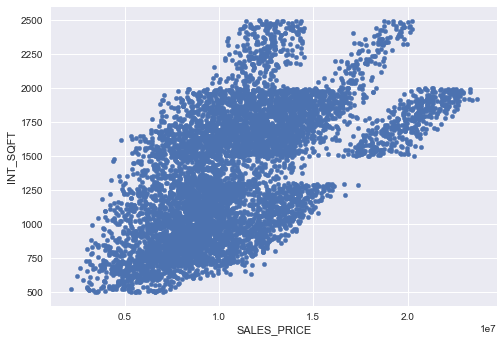

In [14]:
var = 'SALES_PRICE'
data = pd.concat([train['INT_SQFT'], train[var]], axis=1)
data.plot.scatter(x=var, y='INT_SQFT');        # ylim=(0,2500)

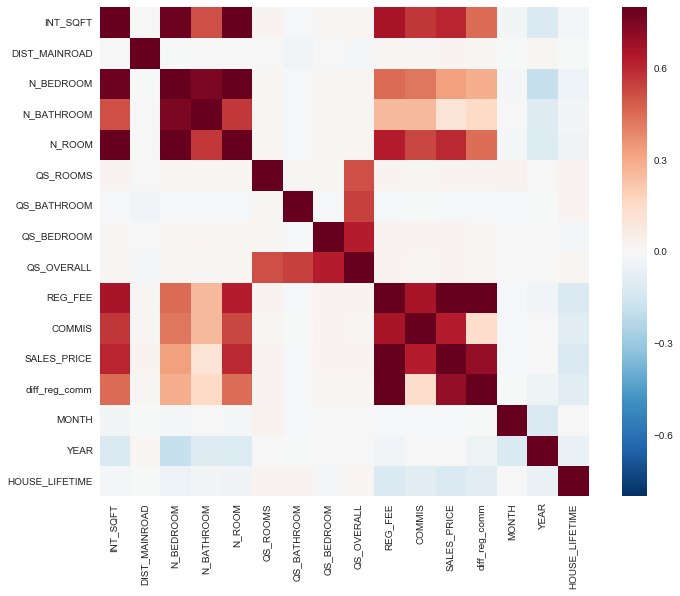

In [15]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [16]:
feature_names = [x for x in train.columns if x not in ['PRT_ID','SALES_PRICE','DATE_SALE','DATE_BUILD']]
target = train['SALES_PRICE']

In [17]:
train[feature_names].dtypes

AREA               object
INT_SQFT            int64
DIST_MAINROAD       int64
N_BEDROOM         float64
N_BATHROOM        float64
N_ROOM              int64
SALE_COND          object
PARK_FACIL         object
BUILDTYPE          object
UTILITY_AVAIL      object
STREET             object
MZZONE             object
QS_ROOMS          float64
QS_BATHROOM       float64
QS_BEDROOM        float64
QS_OVERALL        float64
REG_FEE             int64
COMMIS              int64
diff_reg_comm       int64
MONTH               int64
YEAR                int64
HOUSE_LIFETIME    float64
dtype: object

In [226]:
# Current best
from catboost import CatBoostRegressor

model_catboost = CatBoostRegressor(eval_metric='RMSE',learning_rate=0.3,verbose=True, iterations=400,depth=16)

model_catboost.fit(train[feature_names], target, cat_features=[0,  5,  6,  7,  8,  9, 10, 11, 19, 20])

pred = model_catboost.predict(test[feature_names])

pred[:10]

Borders generated
0:	learn 8222594.553passed: 0.0216 sec	total: 621ms	remaining: 1m 1s
1:	learn 5939929.272passed: 0.139 sec	total: 761ms	remaining: 37.3s
2:	learn 4336872.985passed: 0.075 sec	total: 836ms	remaining: 27s
3:	learn 3237527.48passed: 0.0273 sec	total: 864ms	remaining: 20.7s
4:	learn 2418914.745passed: 0.301 sec	total: 1.17s	remaining: 22.2s
5:	learn 1865481.245passed: 1.38 sec	total: 2.55s	remaining: 39.9s
6:	learn 1486649.639passed: 9.08 sec	total: 11.6s	remaining: 2m 34s
7:	learn 1218674.048passed: 34.6 sec	total: 46.2s	remaining: 8m 51s
8:	learn 1051775.5passed: 0.0921 sec	total: 46.3s	remaining: 7m 48s
9:	learn 923942.99passed: 8.16 sec	total: 54.5s	remaining: 8m 10s
10:	learn 834883.5736passed: 0.64 sec	total: 55.1s	remaining: 7m 25s
11:	learn 752580.8032passed: 1.09 sec	total: 56.2s	remaining: 6m 52s
12:	learn 708647.2095passed: 0.263 sec	total: 56.5s	remaining: 6m 17s
13:	learn 668392.8228passed: 2.97 sec	total: 59.4s	remaining: 6m 5s
14:	learn 643185.0465passed: 1

array([  7727604.09432117,  14475410.31544828,   7998172.15393278,
        13957202.56556859,   6895050.71776128,  14396235.22822814,
        14869148.96145219,  21817522.6376007 ,  14813530.6068729 ,
         5773579.41069838])

In [227]:
## make submission
sub = pd.DataFrame()
sub['PRT_ID'] = test['PRT_ID']
sub['SALES_PRICE'] = pred
sub.to_csv('house_prices.csv', index=False)